<a href="https://colab.research.google.com/github/anuarsantoyo/master-thesis/blob/master/evaluation_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import imageio
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

# Import Data

In [5]:
#%cd ..

In [6]:
df, cluster_input_cols, answers_train, answers, labels, _ = get_cluster_data(n_cluster=5, method='gmm', cov_type='full', cluster_input_data='fa_data', start_train='2020-07-31', end_train='2020-12-01')

# Metrics

In [7]:
ch_score = metrics.calinski_harabasz_score(answers, labels)
silhouette_score = metrics.silhouette_score(answers, labels, metric='euclidean')
print('Calinski Harabasz Score: ' + str(ch_score))
print('Silhouette Score: ' + str(silhouette_score))

Calinski Harabasz Score: 5794.043046522125
Silhouette Score: 0.049754463017641255


# Plot Group Size

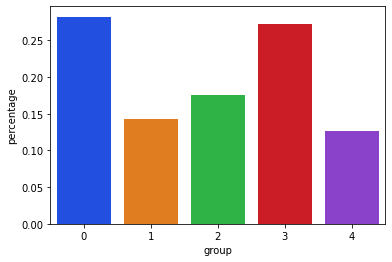

In [8]:
df_group_size = df[['group', 'gender']].groupby('group').count().reset_index()
df_group_size['gender'] = df_group_size['gender'] / df_group_size['gender'].sum()
df_group_size.rename(columns={'gender':'percentage'}, inplace=True)
sns.barplot(data=df_group_size, x='group', y='percentage', palette='bright')

In [9]:
df_group_size

,group,percentage
0,0,0.282182
1,1,0.143155
2,2,0.176077
3,3,0.272229
4,4,0.126356


# Daily Distribution

In [10]:
groups_percentage = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = groups_percentage[groups_percentage['date']==row['date']]['gender'].sum()
  return row['gender']/sum

groups_percentage['percentage'] = groups_percentage.apply(lambda x: normalize(x), axis=1)
groups_percentage['date'] = pd.to_datetime(groups_percentage['date'])
groups_percentage.drop(columns='gender',inplace=True)
fig = px.line(groups_percentage, x="date", y="percentage", color='group', title='Group daily distribution')
fig.show()

# Pairgrid Factors

In [11]:
start = '2020-09-01'
end = '2020-09-14'
in_range = (df.date > start) & (df.date < end)
df_timewindow = df[in_range]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions

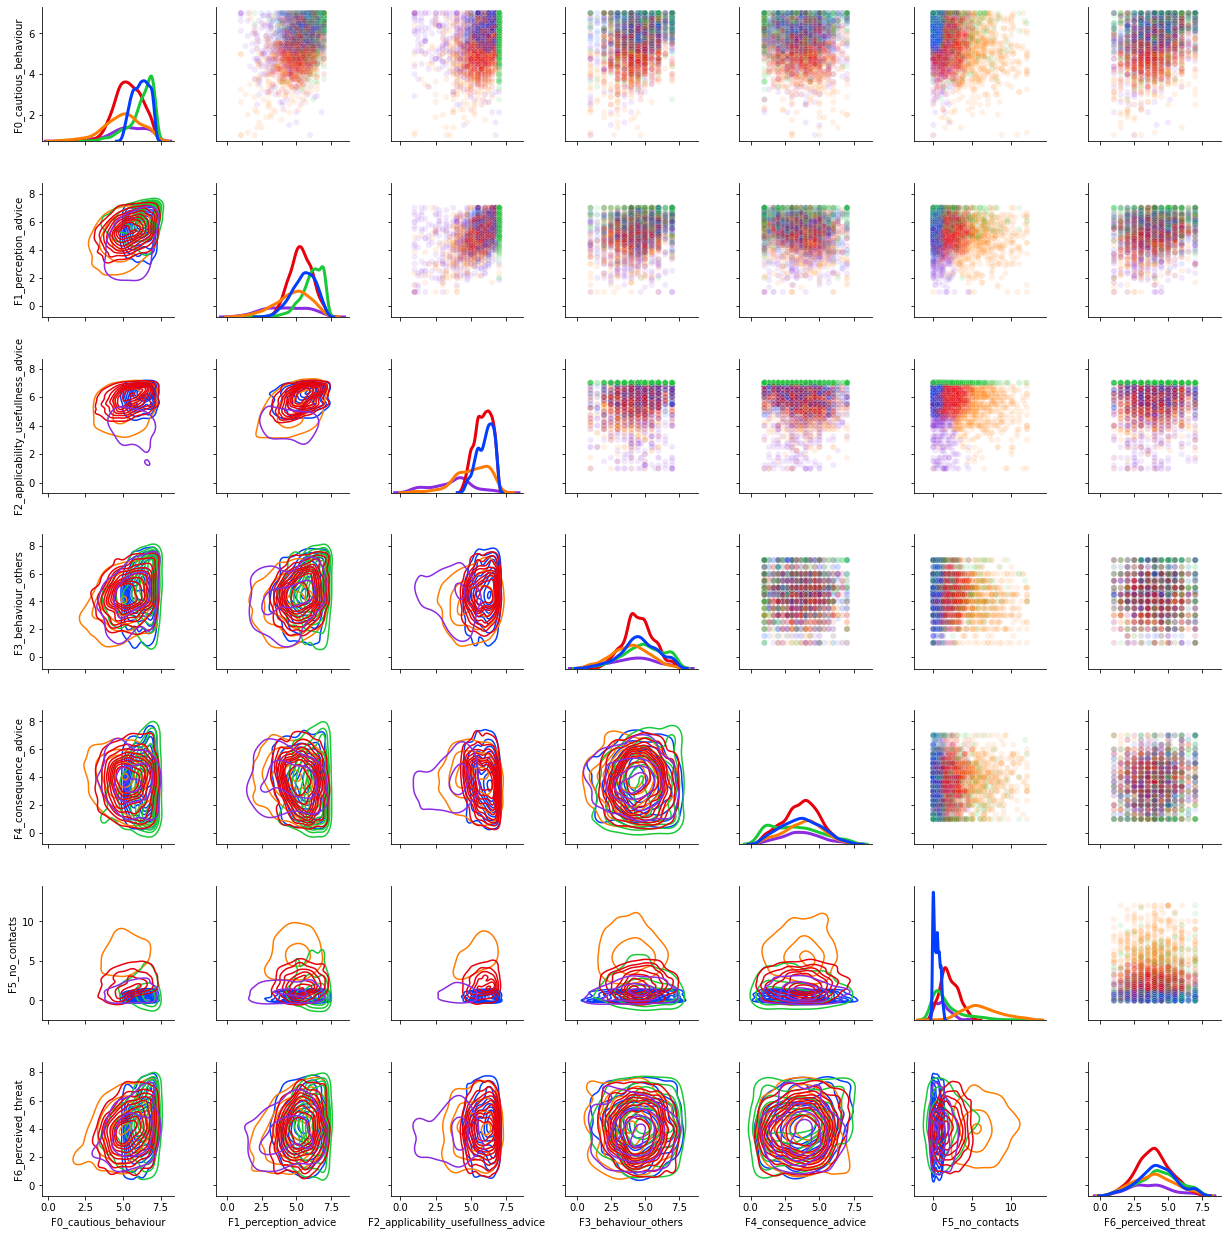

In [12]:
%matplotlib inline
g = sns.PairGrid(data=df_timewindow, vars=cluster_input_cols, hue='group', palette='bright')
g.map_upper(sns.scatterplot, alpha=0.1)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

# 3D Scatterplot

In [29]:
df_timewindow.group = df_timewindow.group.astype(str)
fig = px.scatter_3d(df_timewindow, x=cluster_input_cols[0], y=cluster_input_cols[2], z=cluster_input_cols[5], color='group', opacity=1)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=5, range=[0, 7],),
                     yaxis = dict(nticks=5, range=[0, 7],),
                     zaxis = dict(nticks=5, range=[0, 12],),),
        width=1600, height=700, margin=dict(r=20, l=10, b=10, t=10))
fig.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Daily Average Group Answer

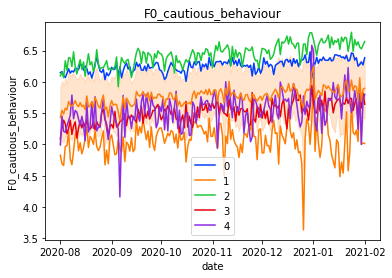

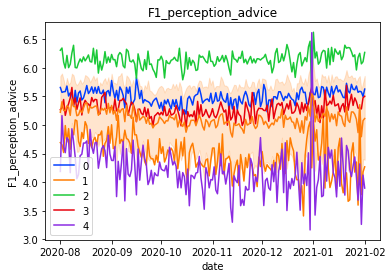

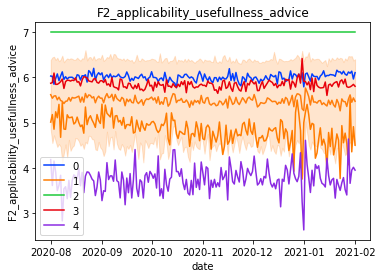

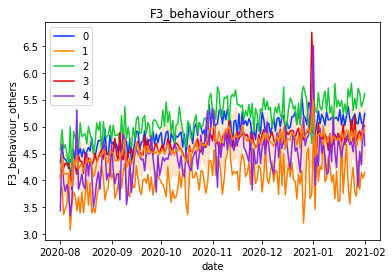

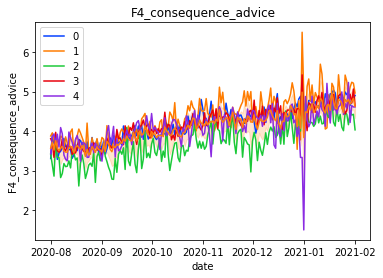

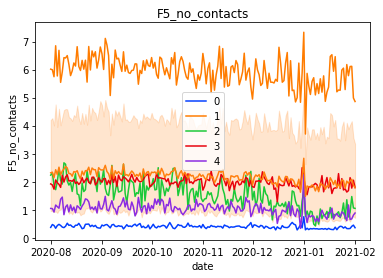

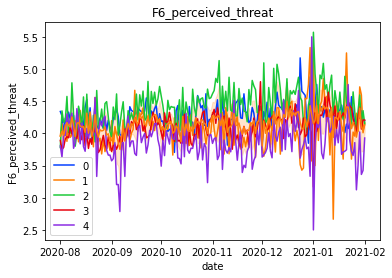

In [20]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average.date = pd.to_datetime(df_daily_average.date)
for col in cluster_input_cols:
    sns.lineplot(data=df_daily_average, x='date', y=col, hue='group', palette="bright")
    sns.lineplot(data=df_daily_average, x='date', y=col)
    plt.title(col)
    plt.show()

# Observations

In [15]:
observations = pd.read_csv('data/observations_30012022.csv',sep=';', decimal=',', encoding='utf-8', index_col='Unnamed: 0')
observations.Date = pd.to_datetime(observations.Date, format='%Y-%m-%d')
start = '2020-08-01'
end = '2021-02-01'
in_range = (observations.Date > start) & (observations.Date < end)
observations = observations[in_range]
observations.head()

,Date,Number_of_deaths,Cumulative_number_of_deaths,Confirmed_cases,Admissions_hospital
157,2020-08-02,0,616,78,2
158,2020-08-03,0,616,117,7
159,2020-08-04,0,616,121,5
160,2020-08-05,1,617,116,7
161,2020-08-06,0,617,171,3


In [16]:
fig = px.line(observations, x="Date", y=['Confirmed_cases', 'Admissions_hospital'])
fig.show()

# Group distance

In [17]:
df_dict = []
for i, day in  df[behaviour_cols + ['date', 'group']].groupby(['date']):
     groups_dist = np.abs(day[day['group']== 0].mean() - day[day['group']== 1].mean())
     dist = np.linalg.norm(groups_dist.values, ord=1)
     df_dict.append({'time':i, 'distance': dist})
dist_df = pd.DataFrame(df_dict)
dist_df['dist_smooth'] = dist_df.distance.rolling(7).mean()
fig = px.line(dist_df,x='time', y=['distance', 'dist_smooth'])
fig.show()

# GIF Creation

In [18]:
"""df_timeframe = df.copy()
df_timeframe['date'] = pd.to_datetime(df_timeframe['date'])

plt.ioff()
for nr_weeks in range(52):
  dt_start_temp = df_timeframe.date.min() + timedelta(days=7) * nr_weeks
  dt_end_temp = dt_start_temp + timedelta(days=14)
  time_window = (df_timeframe['date'] > dt_start_temp) & (df_timeframe['date'] < dt_end_temp)
  df_timeframe_temp = df_timeframe[time_window]


  g = sns.JointGrid(data=df_timeframe_temp, x=top_cols[1], y=top_cols[2], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
  g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot #kdeplot
  g.plot_marginals(sns.histplot, kde=True) #or kdeplot
  fig = g.fig
  fig.suptitle(dt_start_temp.strftime("%Y-%m-%d") + ' - ' + dt_end_temp.strftime("%Y-%m-%d"))
  fig.savefig("gif_creation/images/out_"+dt_start_temp.strftime("%Y_%m_%d") + ".png")
  plt.close(fig)"""

'df_timeframe = df.copy()\ndf_timeframe[\'date\'] = pd.to_datetime(df_timeframe[\'date\'])\n\nplt.ioff()\nfor nr_weeks in range(52):\n  dt_start_temp = df_timeframe.date.min() + timedelta(days=7) * nr_weeks\n  dt_end_temp = dt_start_temp + timedelta(days=14)\n  time_window = (df_timeframe[\'date\'] > dt_start_temp) & (df_timeframe[\'date\'] < dt_end_temp)\n  df_timeframe_temp = df_timeframe[time_window]\n\n\n  g = sns.JointGrid(data=df_timeframe_temp, x=top_cols[1], y=top_cols[2], hue="group", palette=\'bright\', height=8) # hue_order=[1, 2, 0],\n  g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot #kdeplot\n  g.plot_marginals(sns.histplot, kde=True) #or kdeplot\n  fig = g.fig\n  fig.suptitle(dt_start_temp.strftime("%Y-%m-%d") + \' - \' + dt_end_temp.strftime("%Y-%m-%d"))\n  fig.savefig("gif_creation/images/out_"+dt_start_temp.strftime("%Y_%m_%d") + ".png")\n  plt.close(fig)'

In [19]:
"""# Create GIF
images = []
path = 'gif_creation/images/'

for filename in os.listdir(path):
  images.append(imageio.imread(path+filename))
  os.remove(path+filename)
imageio.mimsave('gif_creation/gmm_grouped.gif', images, duration=0.5)"""

"# Create GIF\nimages = []\npath = 'gif_creation/images/'\n\nfor filename in os.listdir(path):\n  images.append(imageio.imread(path+filename))\n  os.remove(path+filename)\nimageio.mimsave('gif_creation/gmm_grouped.gif', images, duration=0.5)"